# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42) # this is how to set a random seed.

#### Display options

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Jupytper Config
%config Completer.use_jedi = False
%config IPCompleter.greedy=True
pd.set_option('display.max_columns', None)


## Load Exernal Files

In [3]:
# Data file produced by tests.
uf = pd.read_csv('./CSV/colour_data_clustered.csv')

In [4]:
print(f"Unique Cluster Classifications: {uf['cluster_classification'].nunique()}")
uf.head(3)

Unique Cluster Classifications: 4


user  correct recorded_result mask_image  cb_type1  cb_type2  ncb  \
0  unknown_1        1               5          5         0         0    1   
1  unknown_1        1               C          C         0         0    1   
2  unknown_1        1               D          D         0         0    1   

        datetime  random_spread pallet_used  \
0  16/6/20 11:22             10        bear   
1  16/6/20 11:20             10        bear   
2  16/6/20 11:30             10        bear   

                                       pallet_values  \
0  [#e26f39,#f6c458,#e09c3e,#e69e40,#ed7b3d,#f5be...   
1  [#e26f39,#f6c458,#e09c3e,#e69e40,#ed7b3d,#f5be...   
2  [#e26f39,#f6c458,#e09c3e,#e69e40,#ed7b3d,#f5be...   

                                       ishihara_list  \
0  [(220,105,53),(239,192,86),(227,162,61),(222,1...   
1  [(232,116,65),(247,198,95),(221,152,56),(220,1...   
2  [(226,114,54),(253,186,87),(233,148,70),(236,1...   

                                           COLORS_ON  \
0  [(220,105,53),(239,192,86),(227,162,61),(222,1...   
1  [(232,116,65),(247,198,95),(221,152,56),(220,1...   
2  [(226,114,54),(253,186,87),(233,148,70),(236,1...   

                                          COLORS_OFF  cluster_classification  
0  [(71,138,38),(92,73,38),(153,165,49),(221,221,...                       0  
1  [(65,149,38),(99,72,41),(168,165,50),(223,211,...                       0  
2  [(75,142,40),(96,64,34),(162,152,41),(224,219,...                       0

### Categorical Feature Encoding

In [5]:
uf.columns

Index(['user', 'correct', 'recorded_result', 'mask_image', 'cb_type1',
       'cb_type2', 'ncb', 'datetime', 'random_spread', 'pallet_used',
       'pallet_values', 'ishihara_list', 'COLORS_ON', 'COLORS_OFF',
       'cluster_classification'],
      dtype='object')

### Define Input vectors (X)

In [6]:
# pallet used is the most important feature
pallet_dummies = pd.get_dummies(uf['pallet_used'],prefix='pallet_')
X = uf.drop(['user','recorded_result','mask_image','datetime','random_spread','pallet_values','pallet_used','ishihara_list','COLORS_ON','COLORS_OFF','cluster_classification'],axis=1)
X = pd.concat([X,pallet_dummies],axis=1)
X

correct  cb_type1  cb_type2  ncb  pallet__bear  pallet__bluey2  \
0           1         0         0    1             1               0   
1           1         0         0    1             1               0   
2           1         0         0    1             1               0   
3           1         0         0    1             1               0   
4           0         0         0    1             1               0   
...       ...       ...       ...  ...           ...             ...   
5816        1         0         1    1             0               0   
5817        1         0         1    1             0               0   
5818        1         0         1    1             0               0   
5819        1         0         1    1             0               0   
5820        1         0         1    1             0               0   

      pallet__camo2  pallet__greys  pallet__inverse_ring  pallet__orn_grn  \
0                 0              0                     0                0   
1                 0              0                     0                0   
2                 0              0                     0                0   
3                 0              0                     0                0   
4                 0              0                     0                0   
...             ...            ...                   ...              ...   
5816              0              0                     0                0   
5817              0              0                     0                0   
5818              0              0                     0                0   
5819              0              0                     0                0   
5820              0              0                     0                0   

      pallet__pinks  pallet__reversed_ring  pallet__ring  pallet__standard_1  \
0                 0                      0             0                   0   
1                 0                      0             0                   0   
2                 0                      0             0                   0   
3                 0                      0             0                   0   
4                 0                      0             0                   0   
...             ...                    ...           ...                 ...   
5816              0                      0             0                   0   
5817              0                      0             0                   0   
5818              0                      0             0                   0   
5819              0                      0             0                   0   
5820              0                      0             0                   0   

      pallet__standard_2  pallet__standard_3  
0                      0                   0  
1                      0                   0  
2                      0                   0  
3                      0                   0  
4                      0                   0  
...                  ...                 ...  
5816                   0                   1  
5817                   0                   1  
5818                   0                   1  
5819                   0                   1  
5820                   0                   1  

[5821 rows x 16 columns]

### Define target values (y)
We have a categorical target, so we need to labelEncode

## Establish a baseline
Predicting that someone is not colourblind.

In [7]:
baseline = uf['cluster_classification'].value_counts(normalize = True)
print("Correct Answer Baseline:")
print(baseline)

baseline = np.mean(uf['cluster_classification'] == 0)

Correct Answer Baseline:
0    0.812232
3    0.078681
1    0.066140
2    0.042948
Name: cluster_classification, dtype: float64


In [8]:
y = uf['cluster_classification']

le = LabelEncoder()
le.fit_transform(y)

print(f'Transformed {le.classes_.shape}/{uf.cluster_classification.nunique()} labels')
print(f'labels are {le.classes_}')
y

Transformed (4,)/4 labels
labels are [0 1 2 3]


0       0
1       0
2       0
3       0
4       0
       ..
5816    0
5817    0
5818    0
5819    0
5820    0
Name: cluster_classification, Length: 5821, dtype: int64

In [9]:
# y.replace({0: '80%', 1: '.07%', 2: '.66%', 3: '.04%'})

Check columns are equal legnth

In [10]:
print(f'We have {len(y)} y and {len(X)} X values')

We have 5821 y and 5821 X values


## Scaling

In [11]:
def scale_numerical(data,scaler):
    features = data.select_dtypes(exclude=['object']).columns # list of colnames to include in transform
    if scaler == 'ss':
        scaled_features = pd.DataFrame(StandardScaler().fit_transform(data[features]),columns=data.columns) # applies the Standard scaler
    else:
        scaled_features = pd.DataFrame(MinMaxScaler().fit_transform(data[features]),columns=data.columns) # applies the MinMaxScaler scale
    
    return scaled_features

scale_numerical(X,'mm') # just to test.

correct  cb_type1  cb_type2  ncb  pallet__bear  pallet__bluey2  \
0         1.0       0.0       0.0  1.0           1.0             0.0   
1         1.0       0.0       0.0  1.0           1.0             0.0   
2         1.0       0.0       0.0  1.0           1.0             0.0   
3         1.0       0.0       0.0  1.0           1.0             0.0   
4         0.0       0.0       0.0  1.0           1.0             0.0   
...       ...       ...       ...  ...           ...             ...   
5816      1.0       0.0       1.0  1.0           0.0             0.0   
5817      1.0       0.0       1.0  1.0           0.0             0.0   
5818      1.0       0.0       1.0  1.0           0.0             0.0   
5819      1.0       0.0       1.0  1.0           0.0             0.0   
5820      1.0       0.0       1.0  1.0           0.0             0.0   

      pallet__camo2  pallet__greys  pallet__inverse_ring  pallet__orn_grn  \
0               0.0            0.0                   0.0              0.0   
1               0.0            0.0                   0.0              0.0   
2               0.0            0.0                   0.0              0.0   
3               0.0            0.0                   0.0              0.0   
4               0.0            0.0                   0.0              0.0   
...             ...            ...                   ...              ...   
5816            0.0            0.0                   0.0              0.0   
5817            0.0            0.0                   0.0              0.0   
5818            0.0            0.0                   0.0              0.0   
5819            0.0            0.0                   0.0              0.0   
5820            0.0            0.0                   0.0              0.0   

      pallet__pinks  pallet__reversed_ring  pallet__ring  pallet__standard_1  \
0               0.0                    0.0           0.0                 0.0   
1               0.0                    0.0           0.0                 0.0   
2               0.0                    0.0           0.0                 0.0   
3               0.0                    0.0           0.0                 0.0   
4               0.0                    0.0           0.0                 0.0   
...             ...                    ...           ...                 ...   
5816            0.0                    0.0           0.0                 0.0   
5817            0.0                    0.0           0.0                 0.0   
5818            0.0                    0.0           0.0                 0.0   
5819            0.0                    0.0           0.0                 0.0   
5820            0.0                    0.0           0.0                 0.0   

      pallet__standard_2  pallet__standard_3  
0                    0.0                 0.0  
1                    0.0                 0.0  
2                    0.0                 0.0  
3                    0.0                 0.0  
4                    0.0                 0.0  
...                  ...                 ...  
5816                 0.0                 1.0  
5817                 0.0                 1.0  
5818                 0.0                 1.0  
5819                 0.0                 1.0  
5820                 0.0                 1.0  

[5821 rows x 16 columns]

# Classisification
This is mostly experimental as the best model/process for classifying users is developed.

### Model Evaluation Function

In [12]:
# Evaluate Models
def model_evaluate(model):
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.15)
    
    m = model
    # Fit Model
    m.fit(X_train, y_train)
    
    # Predict
    y_pred = m.predict(X_test)
    
    # Scores
    score = cross_val_score(m, X, y, cv = 5) #cross validation of 5.
    score_test = accuracy_score(y_test, y_pred)
    
    #Results
    print(f"{(y_test != y_pred).sum()}/{X_test.shape[0]} points mislabeled")
    print(f"Cross Val Scores: {score}")
    print('Score Average: %.3f' %score_test)
    print('baseline: %.3f' %baseline)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    print('-'*55)
    print(classification_report(y_test, y_pred,zero_division=1))
    return 

### LogisticRegression

In [13]:
from sklearn.linear_model import LogisticRegression
m = model_evaluate(LogisticRegression(max_iter=300))
lg = m

188/874 points mislabeled
Cross Val Scores: [0.81201717 0.81271478 0.60137457 0.81185567 0.81185567]
Score Average: 0.785
baseline: 0.812
Accuracy: 0.77 (+/- 0.17)
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       686
           1       1.00      0.00      0.00        76
           2       1.00      0.00      0.00        38
           3       1.00      0.00      0.00        74

    accuracy                           0.78       874
   macro avg       0.95      0.25      0.22       874
weighted avg       0.83      0.78      0.69       874



### Naive Bayes

In [14]:
from sklearn.naive_bayes import BernoulliNB
m = model_evaluate(BernoulliNB())
nb = m

188/874 points mislabeled
Cross Val Scores: [0.23433476 0.51632302 0.18298969 0.48109966 0.26116838]
Score Average: 0.785
baseline: 0.812
Accuracy: 0.34 (+/- 0.27)
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       686
           1       1.00      0.00      0.00        76
           2       1.00      0.00      0.00        38
           3       1.00      0.00      0.00        74

    accuracy                           0.78       874
   macro avg       0.95      0.25      0.22       874
weighted avg       0.83      0.78      0.69       874



### Support Vector Classifier

In [15]:
from sklearn.svm import SVC
m = model_evaluate(SVC(C=1,kernel='rbf',degree=4))
svc = m

188/874 points mislabeled
Cross Val Scores: [0.81201717 0.81271478 0.60137457 0.79553265 0.81185567]
Score Average: 0.785
baseline: 0.812
Accuracy: 0.77 (+/- 0.17)
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       686
           1       1.00      0.00      0.00        76
           2       1.00      0.00      0.00        38
           3       1.00      0.00      0.00        74

    accuracy                           0.78       874
   macro avg       0.95      0.25      0.22       874
weighted avg       0.83      0.78      0.69       874



### KNN Classifier

In [16]:
from sklearn.neighbors import KNeighborsClassifier
m = model_evaluate(KNeighborsClassifier(n_neighbors=5))
knn = m

192/874 points mislabeled
Cross Val Scores: [0.73819742 0.81271478 0.43041237 0.73797251 0.81185567]
Score Average: 0.780
baseline: 0.812
Accuracy: 0.71 (+/- 0.28)
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       686
           1       1.00      0.00      0.00        76
           2       0.20      0.05      0.08        38
           3       1.00      0.00      0.00        74

    accuracy                           0.78       874
   macro avg       0.75      0.26      0.24       874
weighted avg       0.80      0.78      0.69       874



### Adaboost Classifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier
m = model_evaluate(AdaBoostClassifier(n_estimators=100))
abc = m

188/874 points mislabeled
Cross Val Scores: [0.81201717 0.81271478 0.48195876 0.81185567 0.81185567]
Score Average: 0.785
baseline: 0.812
Accuracy: 0.75 (+/- 0.26)
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       686
           1       1.00      0.00      0.00        76
           2       1.00      0.00      0.00        38
           3       1.00      0.00      0.00        74

    accuracy                           0.78       874
   macro avg       0.95      0.25      0.22       874
weighted avg       0.83      0.78      0.69       874



### MPL Classifier

In [18]:
from sklearn.neural_network import MLPClassifier
m = model_evaluate(MLPClassifier(solver='lbfgs', hidden_layer_sizes=(20, ), max_iter=1000, random_state=42))

188/874 points mislabeled
Cross Val Scores: [0.81201717 0.81271478 0.48195876 0.79553265 0.81185567]
Score Average: 0.785
baseline: 0.812
Accuracy: 0.74 (+/- 0.26)
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       686
           1       1.00      0.00      0.00        76
           2       1.00      0.00      0.00        38
           3       1.00      0.00      0.00        74

    accuracy                           0.78       874
   macro avg       0.95      0.25      0.22       874
weighted avg       0.83      0.78      0.69       874



### Random Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestClassifier
m = model_evaluate(RandomForestClassifier(max_depth=100, random_state=42))

188/874 points mislabeled
Cross Val Scores: [0.81201717 0.81271478 0.48195876 0.79553265 0.81185567]
Score Average: 0.785
baseline: 0.812
Accuracy: 0.74 (+/- 0.26)
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       686
           1       1.00      0.00      0.00        76
           2       1.00      0.00      0.00        38
           3       1.00      0.00      0.00        74

    accuracy                           0.78       874
   macro avg       0.95      0.25      0.22       874
weighted avg       0.83      0.78      0.69       874



In [20]:
import random
test = random.randint(X.index.min(), X.index.max())
predict = X.iloc[[11]]
predict

correct  cb_type1  cb_type2  ncb  pallet__bear  pallet__bluey2  \
11        1         0         0    1             1               0   

    pallet__camo2  pallet__greys  pallet__inverse_ring  pallet__orn_grn  \
11              0              0                     0                0   

    pallet__pinks  pallet__reversed_ring  pallet__ring  pallet__standard_1  \
11              0                      0             0                   0   

    pallet__standard_2  pallet__standard_3  
11                   0                   0

In [21]:
rfc = RandomForestClassifier(max_depth=100, random_state=42)
# Fit Model
rfc.fit(X,y)
# Predict
[y_pred] = rfc.predict(predict)
print(y_pred)

0


## Rebuild X & Apply Labels

In [22]:
X = uf.drop(['user','recorded_result','mask_image','datetime','random_spread','pallet_values','pallet_used','ishihara_list','COLORS_ON','COLORS_OFF','cluster_classification'],axis=1)
X = pd.concat([X,pallet_dummies],axis=1)

In [23]:
# Evaluate Models
def predict_labels(model):
    m = model
    m.fit(X,y)
    y_pred = m.predict(X)
    return y_pred

In [24]:
predict_labels(LogisticRegression(max_iter=300))
uf['LogisticRegressor'] = y_pred

predict_labels(AdaBoostClassifier(n_estimators=100))
uf['AdaBoostClassifier'] = y_pred

predict_labels(BernoulliNB())
uf['BernoulliNB'] = y_pred

predict_labels(SVC(C=1,kernel='rbf',degree=4))
uf['SVC'] = y_pred

predict_labels(KNeighborsClassifier(n_neighbors=5))
uf['KNN'] = y_pred

predict_labels(RandomForestClassifier(max_depth=100, random_state=42))
uf['RFC'] = y_pred

print('AdaBoostClassifier returned the following classifications:')
print(uf['AdaBoostClassifier'].value_counts())
print('\n')
print('Naive Bayes Classifier returned the following classifications:')
print(uf['BernoulliNB'].value_counts())
print('\n')
print('SVC Classifier returned the following classifications:')
print(uf['SVC'].value_counts())
print('\n')
print('KNN Classifier returned the following classifications:')
print(uf['KNN'].value_counts())
print('\n')
print('RF Classifier returned the following classifications:')
print(uf['RFC'].value_counts())
print('\n')

AdaBoostClassifier returned the following classifications:
0    5821
Name: AdaBoostClassifier, dtype: int64


Naive Bayes Classifier returned the following classifications:
0    5821
Name: BernoulliNB, dtype: int64


SVC Classifier returned the following classifications:
0    5821
Name: SVC, dtype: int64


KNN Classifier returned the following classifications:
0    5821
Name: KNN, dtype: int64


RF Classifier returned the following classifications:
0    5821
Name: RFC, dtype: int64




In [25]:
for user in uf['user'].unique():
    evaluation = uf[uf['user'] == user]
    print(f'for user: {str(user)}')
    print(f"cluster_classification: 	{evaluation['cluster_classification'].unique()}")
    print(f"AdaBoostClassifier:		{evaluation['AdaBoostClassifier'].unique()}")
    print(f"BernoulliNB: 			{evaluation['BernoulliNB'].unique()}")
    print(f"SVC: 				{evaluation['SVC'].unique()}")
    print('---'*10)


for user: unknown_1
cluster_classification: 	[0]
AdaBoostClassifier:		[0]
BernoulliNB: 			[0]
SVC: 				[0]
------------------------------
for user: male_ncb_2
cluster_classification: 	[0]
AdaBoostClassifier:		[0]
BernoulliNB: 			[0]
SVC: 				[0]
------------------------------
for user: colourblind_type1_3
cluster_classification: 	[1]
AdaBoostClassifier:		[0]
BernoulliNB: 			[0]
SVC: 				[0]
------------------------------
for user: unknown_4
cluster_classification: 	[0]
AdaBoostClassifier:		[0]
BernoulliNB: 			[0]
SVC: 				[0]
------------------------------
for user: unknown_5
cluster_classification: 	[0]
AdaBoostClassifier:		[0]
BernoulliNB: 			[0]
SVC: 				[0]
------------------------------
for user: unknown_6
cluster_classification: 	[0]
AdaBoostClassifier:		[0]
BernoulliNB: 			[0]
SVC: 				[0]
------------------------------
for user: unknown_7
cluster_classification: 	[0]
AdaBoostClassifier:		[0]
BernoulliNB: 			[0]
SVC: 				[0]
------------------------------
for user: male_8
cluste

## Save To File

In [26]:
uf.to_csv('./CSV/colour_data_classified.csv', header=True,index=False)

# fin Part 1
# Commence Part 2

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [162]:
class Model(nn.Module): # model class object inherited from nn.Module
    
    def __init__(self, in_features=55, h1=80, h2=80, out_features=4):
        # how many layers?
        super().__init__()  # this instanciates the Module class we're inheriting from.
        
        # Input Layer (4 features) --> h1 (hidden layer) N --> h2 (hidden layer) N --> output (3 classes) - of flowers in this case.
        self.fc1 = nn.Linear(in_features, h1) # fully conected (layer 1) i/o
        self.fc2 = nn.Linear(h1,h2)  # i/o
        self.out = nn.Linear(h2, out_features) # i/o
    
    def forward(self, x):
        x = F.relu(self.fc1(x))  # relu = rectified linear unit)
        x = F.relu(self.fc2(x))
        x = self.out(x) 
        
        # we're passing the values through the activation in and out.
        # this is forward propigation.
        
        return x

In [163]:
torch.manual_seed(32)
model = Model()

In [164]:
# Data file produced by tests.
tdf = pd.read_csv('./CSV/colour_data_clustered.csv')

In [165]:
tdf = tdf[['user', 'correct', 'recorded_result', 'mask_image', 'cb_type1', 'cb_type2','ncb', 'cluster_classification']]
tdf.head()

user  correct recorded_result mask_image  cb_type1  cb_type2  ncb  \
0  unknown_1        1               5          5         0         0    1   
1  unknown_1        1               C          C         0         0    1   
2  unknown_1        1               D          D         0         0    1   
3  unknown_1        1               N          N         0         0    1   
4  unknown_1        0               N          E         0         0    1   

   cluster_classification  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0

In [166]:
tdf.user.nunique(), tdf.cluster_classification.nunique()

(30, 4)

In [167]:
len(tdf)

5821

In [168]:
# OneHotEncode
user_dummies = pd.get_dummies(tdf['user'], prefix='user_', drop_first=True)
recorded_result_dummies = pd.get_dummies(tdf['recorded_result'], prefix='recorded_result_', drop_first=True)
mask_image_dummies = pd.get_dummies(tdf['mask_image'], prefix='mask_image_', drop_first=True)

tdf = pd.concat([tdf,user_dummies,recorded_result_dummies,mask_image_dummies], axis=1)


In [169]:
tdf = tdf.drop(['user','recorded_result','mask_image'], axis=1, inplace=False)

In [170]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   correct                     5821 non-null   int64
 1   cb_type1                    5821 non-null   int64
 2   cb_type2                    5821 non-null   int64
 3   ncb                         5821 non-null   int64
 4   cluster_classification      5821 non-null   int64
 5   user__colourblind_type1_3   5821 non-null   uint8
 6   user__colourblind_type2_11  5821 non-null   uint8
 7   user__colourblind_type2_24  5821 non-null   uint8
 8   user__female_16             5821 non-null   uint8
 9   user__female_17             5821 non-null   uint8
 10  user__female_ncb_26         5821 non-null   uint8
 11  user__female_ncb_29         5821 non-null   uint8
 12  user__male_12               5821 non-null   uint8
 13  user__male_13               5821 non-null   uint8
 14  user__ma

In [171]:
# We now need to adjust the number of features in our layers.
len(tdf.columns)
# this is the number of features.

56

In [172]:
X = tdf.drop('cluster_classification', axis=1)
y = tdf['cluster_classification']

In [173]:
type(y) # we need numpy arrays.

pandas.core.series.Series

In [174]:
X = X.values
y = y.values

In [175]:
type(y)

numpy.ndarray

In [176]:
from sklearn.model_selection import train_test_split

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [178]:
# Convert to FloatTensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [179]:
y_train = torch.LongTensor(y_train) # Long
y_test = torch.LongTensor(y_test)

In [180]:
# "criterion on which we are evaluating our networks performance"
# CrossEntropyLoss - "dataset is a multi-class cross entropy problem".
criterion = nn.CrossEntropyLoss() # Comparing our X_train to X_test

In [181]:
# notice we pass our model function object into the optimiser!
# Adam optimiser - one of the most efficient optimisers.
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)  # start here and change if after 10 epochs error is not reducing.

In [182]:
model.parameters # from our class object

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=55, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (out): Linear(in_features=80, out_features=4, bias=True)
)>

#### How Many Epochs?
- An epoch is 1 run through all the training data

In [183]:
epochs = 100
losses = []

for i in range(epochs):
    
    # FORWARDS and get a prediction
    
    y_pred = model.forward(X_train) # goes forward through all the layers.
    
    # Calculate loss/error
    loss = criterion(y_pred, y_train)
    
    losses.append(loss) # keep track of loss.
    
    if i%10 == 0:
        print(f'Epoch {i} and loss is: {loss}')
              
    # BACK PROPAGATION
              
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch 0 and loss is: 1.396665334701538
Epoch 10 and loss is: 0.48063963651657104
Epoch 20 and loss is: 0.3123609125614166
Epoch 30 and loss is: 0.2445378303527832
Epoch 40 and loss is: 0.16790921986103058
Epoch 50 and loss is: 0.09741850197315216
Epoch 60 and loss is: 0.0210780818015337
Epoch 70 and loss is: 0.0016890433616936207
Epoch 80 and loss is: 0.00039347243728116155
Epoch 90 and loss is: 0.00017870408191811293


Text(0.5, 0, 'Epoch')

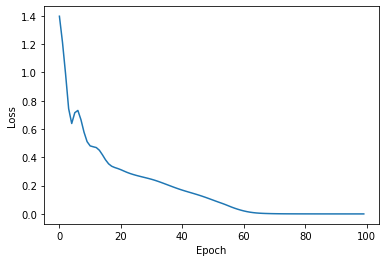

In [186]:
plt.plot(range(epochs),losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [187]:
with torch.no_grad(): # this turns off grad - saves memory and improves efficency.
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)

In [189]:
loss
# Looks like our data is too simple.
# Our test loss is tiny, meaning the score is almost perfect.

tensor(0.0001)

In [198]:
#  Using Cross Entropy Loss followed by Correct Value.

correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
#         print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
        
        # add correct to total tally.
        if y_val.argmax().item() == y_test[i]:
            correct += 1
            
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')


1165 out of 1165 = 100.00% correct


In [193]:
# Again, this suggests we need to improve our test mechanism.

In [195]:
torch.save(model.state_dict(), 'colourdata_classification_model.pt')

In [196]:
model2 = Model()
model2.load_state_dict(torch.load('colourdata_classification_model.pt'))

<All keys matched successfully>

In [197]:
model2.eval()

Model(
  (fc1): Linear(in_features=55, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (out): Linear(in_features=80, out_features=4, bias=True)
)

### Inference

In [244]:
random_row = tdf.drop('cluster_classification', axis=1)  # Take X and drop target
random_row = random_row.sample(n=1)  # Select Random Row from X
random_row = random_row.values  # Change into numpy array
random_row = torch.FloatTensor(random_row)  # Convert that into a torch Float
random_row = [t.numpy() for t in random_row]  # Convert items in list to numpy values
inference_sample = torch.tensor([random_row]) # Convert into torch tensor ready for inference.

with torch.no_grad():
    print(model2(inference_sample)) # prints out a tensor
    print(f'Predicted user type: {model2(inference_sample).argmax()}')

tensor([[[ 11.3065,  -2.4360, -15.3265, -12.4988]]])
Predicted user type: 0


In [ ]:
# Then I just need to add these together and I can derive a mean pr.

In [ ]:
# Consider cleaning with NP cats = np.stack([tdf[col].cat.codes.values for col in cat_cols], axis=1)b